# Classificazione binaria "selfMade" con ANN (MLPClassifier)


In [3]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
import sys
sys.path.append('../Scripts')
from utility import evaluate_and_save_model

X_train = pd.read_csv("../data/splitted/X_train.csv")
X_test = pd.read_csv("../data/splitted/X_test.csv")
y_train = pd.read_csv("../data/splitted/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/splitted/y_test.csv").values.ravel()

In [4]:
X_train = X_train.drop(columns=['source'], errors='ignore')
X_train = X_train.loc[:, X_train.nunique() > 1]
X_test = X_test[X_train.columns]

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parametri utilizzati
- hidden layer sizes = (100,) un solo layer nascosto con 100 neuroni
- relu: funzione ti attivazione
- adam: ottimizzatore adattivo
- alpha= 0.001 regolarizzazzione L2
- early stopping= true significa che interrompe il training se non migliorare su validation set

In [6]:
# Modello MLP
model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.001,
                      early_stopping=True, max_iter=300, random_state=42)
model.fit(X_train_scaled, y_train)


MLPClassifier(alpha=0.001, early_stopping=True, max_iter=300, random_state=42)

In [7]:
# Predizioni
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

evaluate_and_save_model(
    model,
    "ANN",
    y_train,
    y_pred_train,
    y_test,
    y_pred_test,
    "../results/classification_selfMade/ann",
    "../models/ann_selfmade.joblib",
    {"activation":"relu","hidden_layer_sizes":(100,),"alpha":0.001}
)


Visualizzazione della curva loss durante l'addestramento
- Asse x - Epoche: rappresenta il num di iterazioni complete del modello sul training set da 0 a 12
- Asse y - Loss: è la log loss che misura quanto il modello sta sbagliando. Più è bassa, mneglio è

Come possiamo vedere dal grafico l'andamento decresce partendo da circa 0.67 fino a 0.40 indica che il modello sta imparando e sta riducendo gli errori

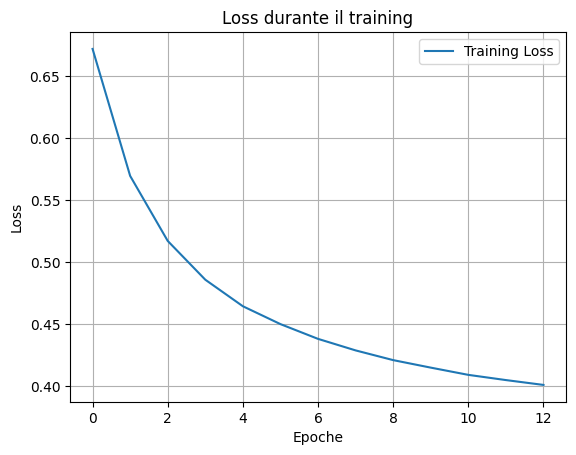

In [8]:
import matplotlib.pyplot as plt

plt.plot(model.loss_curve_, label="Training Loss")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.title("Loss durante il training")
plt.legend()
plt.grid(True)
plt.savefig("../results/classification_selfMade/ann/loss_curve.png")
plt.show()


# Cross validation
viene applicata una 5-fold-cv usando la log-loss come metrica

In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss')


Viene creata una griglia di combinazioni tra dimensioni della rete, funzioni di attivazione, tassi di apprendimento, solver e learning rate al fine di trovare i migliori parametri per il nostro modello.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [
        (50,), (100,), (150,), (100, 50), (64, 32),
        (128, 64), (100, 100), (50, 25), (64, 32, 16), (32, 32, 16)
    ],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'learning_rate_init': [0.001, 0.01, 0.1],
}

mlp = MLPClassifier(
    early_stopping=True,
    max_iter=300,
    random_state=42,
    validation_fraction=0.2,
    n_iter_no_change=10
)

grid = GridSearchCV(
    mlp,
    param_grid,
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Migliori iperparametri trovati:", grid.best_params_)




Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Migliori iperparametri trovati: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50, 25), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'sgd'}


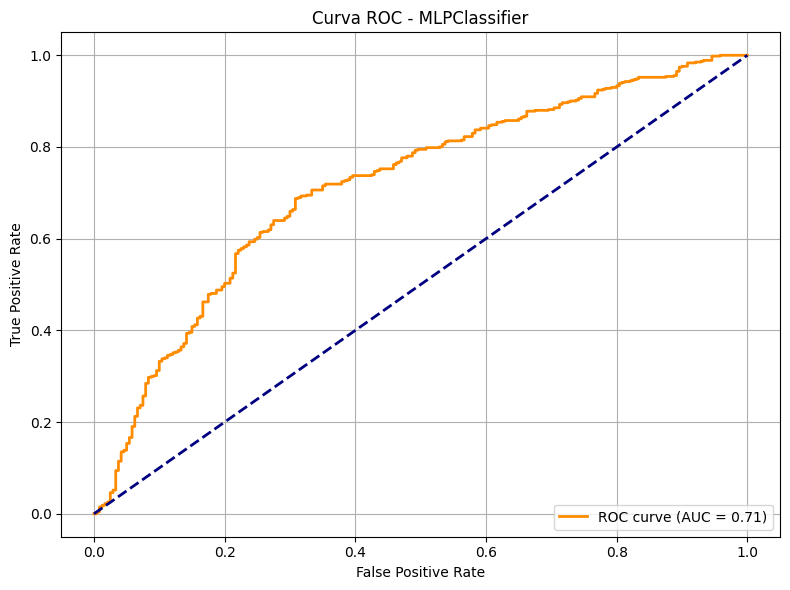

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Calcolo delle probabilità predette
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calcolo della curva ROC
fpr, tpr, soglie = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - MLPClassifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

plt.savefig("../results/classification_selfMade/ann/roc_curveA.png")
plt.show()